# Designing Water Networks with a QUBO approach

In this notebook we present how to optimize the diameters of the pipe of a water network to minimize the cost of the network while keeping the pressure abov a certain threshold. 

The hydraulics equations can be written as:

$$
    \sum_j s_{ij} y_{ij} - D_i = 0 \newline
    h_{L_{ij}} \equiv h_i - h_j = A s_{ij} y_{ij}^{B}
$$

In order to consider several pipe diameters we extend these equations with new variables


$$
    \sum_j s_{ij} y_{ij} - D_i = 0 \newline
    h_{L_{ij}} \equiv h_i - h_j = \sum_d \delta_{d,ij} A_{d,ij} s_{ij} y_{ij}^{B}
$$

where $\delta_{d,ij} = [0,1]$ is used to select a given diameter, $d$, of the pipe $ij$. If only a single $\delta_{d,ij}$ equals 1 while all the other are null, we find the original head loss equation. It is therefore immediately clear that we need to enforce at all time the following condition:

$$
    \sum_d \delta_{d,ij} = 1 \quad \forall \quad ij
$$

For the QUBO problem to also minimize the cost of the total network we need to add one equation:

$$
    \omega_\mu \sum_{ij}\sum_d \delta_{d,ij} \mu_{d,ij} \rightarrow 0
$$

\noindent where $\mu_{d,ij}$ is the price of pipe $ij$ for a diameter $d$. $\omega_\mu$ is a parameter that determines the relative weight of this equation when optimizing the QUBO problem. Finally if we want to constrain the values of the head node we need to impose conditions such as:

$$
    h_k \geq H_{\textnormal{min}} \quad \forall \quad k
$$

these equations are enforced by introducing slack variables and extra penalty terms in the QUBO objective function.

## Example 

We demonstrate here how to optimize the water network using our QUBO approach. We start by defining the network.

In [27]:
import wntr
inp_file = './networks/Net0_CM.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# QUBO Designer

We now show how to optimize the problem using the QUBO designer included in `wntr_quantum`. The unknown of the problem can take continuous values and therefore must be encoded using several qubits before being used in a QUBO formulation. We use here the encoding implemented in our library `qubops`. We use these encoding schemes to instantiate the polynomial solver.

In [28]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.encodings import PositiveQbitEncoding

nqbit = 5
step = (4./(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0.0, var_base_name="x")

nqbit = 7
step = (200/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0.0, var_base_name="x")

We can now create an instance of the designer. We choose to explore a small problem where each pipe can only take 3 distinct values: 250 cm, 500 cm and 1000 cm. We fix the threshold pressure at 29 m. We also adjust the weight of the constraints related to the cost minimization and pressure. 

In [29]:
from wntr_quantum.design.qubo_pipe_diam import QUBODesignPipeDiameter 
pipe_diameters = [250, 500, 1000]
designer = QUBODesignPipeDiameter(wn, flow_encoding, head_encoding, 
                                  pipe_diameters, head_lower_bound=29,
                                  weight_cost=2, weight_pressure=0.5)
designer.verify_encoding()

Head Encoding : 0.000000 => 200.000000 (res: 1.574803)
Flow Encoding : -4.000000 => -0.000000 | 0.000000 => 4.000000 (res: 0.129032)


We can enumerate the possible values of the flow and pressure for all possible values of the pipe diameters

In [30]:
solutions = designer.enumerates_classical_solutions(convert_to_si=True)

price 	 diameters 	 variables	 energy
0.16907910944516957 [250. 250.] [ 0.05   0.05  20.689 11.378] -8896.547627089463
0.25361866416775436 [250. 500.] [ 0.05   0.05  20.689 20.457] -8189.177038991521
0.42269777361292393 [ 250. 1000.] [ 0.05   0.05  20.689 20.683] -8189.351066475922
0.25361866416775436 [500. 250.] [ 0.05   0.05  29.769 20.457] -6581.108863493134
0.33815821889033915 [500. 500.] [ 0.05   0.05  29.769 29.537] -4978.399309341114
0.5072373283355087 [ 500. 1000.] [ 0.05   0.05  29.769 29.763] -4978.458985844512
0.42269777361292393 [1000.  250.] [ 0.05   0.05  29.994 20.683] -6580.062243226369
0.5072373283355087 [1000.  500.] [ 0.05   0.05  29.994 29.763] -4977.238338093348
0.6763164377806783 [1000. 1000.] [ 0.05   0.05  29.994 29.988] -4977.069312634741


### Initial sample for the QUBO optimization 

Before minimizing the energy of the QUBO problem we need to define the initial configuration of the binary variables in the QUBO problem. We have implemented two different ways to obtain an initial sample that respects all the conditions imposed by the quadratization constraings of the polynomial qubo solver. 

We can for example create a completely random sample that simply ensure that quadratization constraints are respected

In [31]:
from wntr_quantum.sampler.simulated_annealing import modify_solution_sample
x = modify_solution_sample(designer, solutions[(500,500)][2], modify=['flows','heads'])
x0 = list(x.values())

### Temperature scheduling for the Simulated Annealing optimization

One important parameters of the simulated Annealing process is the the so-called temperature schedule. This schdule defines the acceptance probability of the new samples that increase the QUBO energy. While high temperature that leads to accepting samples that increase energy is usefull to escape local minima the temperature must be decreased in order to converge towards a minima. 

The temperature schedule usually starts with high temperature values that allows to explore the energy landscape but progressively decrease the tempearture in order for the optimization to converge. 

In [32]:
import numpy as np
num_temp = 5000
Tinit = 1E3
Tfinal = 1E-1
Tschedule = np.linspace(Tinit, Tfinal, num_temp)
Tschedule = np.append(Tschedule, Tfinal*np.ones(1000))
Tschedule = np.append(Tschedule, np.zeros(100))

We can then use the `solve()` method of the qubo polynomial solver to obtain a solution of the problem

In [33]:
designer.step_func.optimize_values = np.arange(2,12)
data = designer.solve(init_sample=x0, Tschedule=Tschedule,
                     save_traj=True, verbose=False)

100%|██████████| 6100/6100 [00:20<00:00, 300.29it/s]


In [34]:
res = data[3]

We can plot the evoluion of the QUBO energy along the optimization path

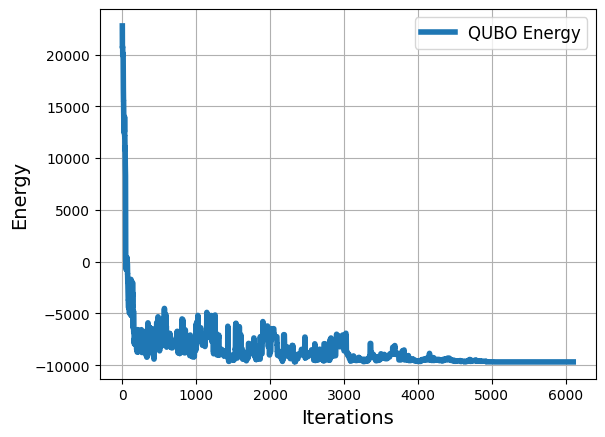

In [35]:
import matplotlib.pyplot as plt
eplt = res.energies
plt.plot(res.energies[:], lw=4, label="QUBO Energy")
plt.grid(which='both')
plt.ylabel('Energy', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.legend(fontsize=12)




We can also extract the price and pipe diameters obtained after the optimization

In [36]:
price = data[4]
diameters = data[5]
print(price, diameters)

0.42269777361292393 [ 250. 1000.]


We can also plot the reference solution and the QUBO solution for visual inspection

In [37]:
sol = data[2]
ref_values = solutions[tuple(diameters)][0]

In [38]:
ref_values

array([ 0.05 ,  0.05 , 20.689, 20.683])

Text(0.5, 1.0, 'Pressure')

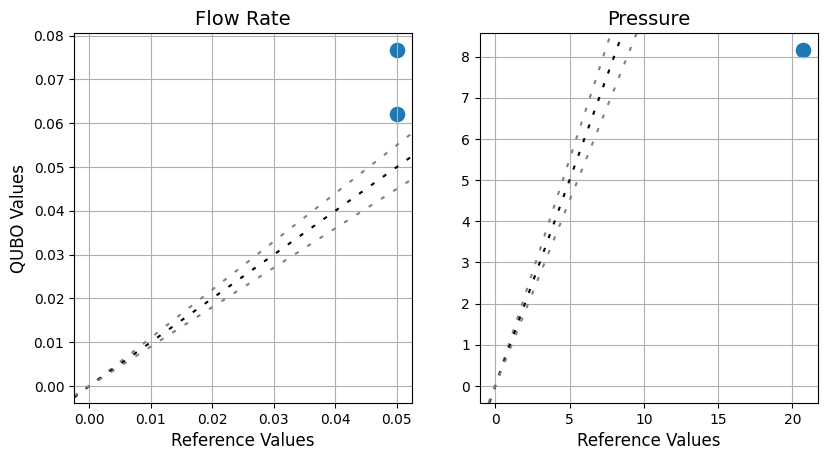

In [39]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize = plt.figaspect(0.5))
ax1 = fig.add_subplot(121)

ax1.axline((0, 0.0), slope=1.10, color="grey", linestyle=(0, (2, 5)))
ax1.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
ax1.axline((0, 0.0), slope=0.90, color="grey", linestyle=(0, (2, 5)))
ax1.grid()

# ax1.scatter(ref_values[:2], encoded_ref_sol[:2], c='black', s=200, label='Best solution')
ax1.scatter(ref_values[:2], sol[:2], s=150, lw=1, edgecolors='w', label='Sampled solution')


ax1.set_xlabel('Reference Values', fontsize=12)
ax1.set_ylabel('QUBO Values', fontsize=12)
ax1.set_title('Flow Rate', fontsize=14)

ax2 = fig.add_subplot(122)

ax2.axline((0, 0.0), slope=1.10, color="grey", linestyle=(0, (2, 5)))
ax2.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
ax2.axline((0, 0.0), slope=0.90, color="grey", linestyle=(0, (2, 5)))


# ax2.scatter(ref_values[2:], encoded_ref_sol[2:], c='black', s=200, label='Best solution')
ax2.scatter(ref_values[2:], sol[2:], s=150, lw=1, edgecolors='w', label='Sampled solution')
ax2.grid()


ax2.set_xlabel('Reference Values', fontsize=12)
ax2.set_title('Pressure', fontsize=14)